In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
from numpy.random import rand
import copy as copy
import warnings


In [2]:
# t -> tmax dividido en pasos de dt
# t, t +dt 
# h : Hazzard Function, Occurrence Rate, Propensities
# 1/h tasa de ocurrencia
#save

class Poisson:

    def __init__(self, h=2, tmax=10, dt=0.01):
        self.h = h
        self.tmax = tmax
        self.dt = dt
        self.protein = 0
        self.t = 0


    def time_calculator(self):
        timer_arr = [0]
        timer_calc = [timer_arr.append(timer_arr[0]+self.dt) for i in range(self.tmax)]
        return timer_arr


    def poisson_sim(self):

        while self.t < self.tmax:

            if self.protein == 0:
                if rand() < self.h * self.dt:
                    self.protein = 1

            if self.protein == 1:
                return self.protein, self.t

            self.t += self.dt


    def poisson_bd(self):

        while self.t < self.tmax:

            if rand() < self.h * self.dt:
                self.protein += 1
            
            self.t += self.dt

        return self.protein
            
            

            

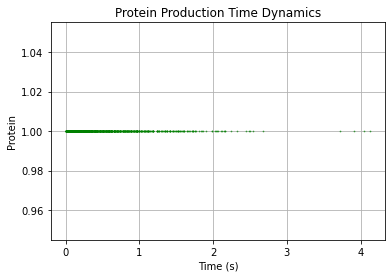

In [3]:
# rand_array = [ 1 for i in range(100000) if rand() < h * dt]
sims_array_1 = []
for i in range(1000):
    simulation_1 = Poisson(h=2, tmax=20, dt=0.01)
    sim_1 = simulation_1.poisson_sim()
    sims_array_1.append(sim_1[1])
    plt.plot(sim_1[1], sim_1[0], 'go', ms=0.8, alpha=0.6);

plt.xlabel('Time (s)')
plt.ylabel('Protein')
plt.title('Protein Production Time Dynamics')
plt.grid(True)


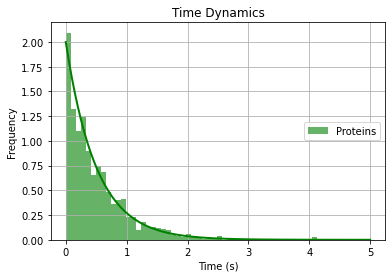

In [4]:
h = 2
time_exp_array = np.linspace(0,5,100)
plt.hist(sims_array_1, bins=50, color='green', alpha=0.6, density=True, label='Proteins');
plt.plot(time_exp_array, h*np.exp(- h * time_exp_array), 'g', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Time Dynamics')
plt.grid(True)
plt.legend(loc=7)

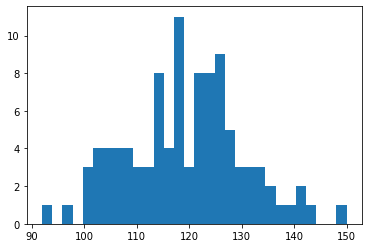

In [5]:
sim_2 = [Poisson(h=2, tmax=60, dt=0.01).poisson_bd() for i in range(100)]
plt.hist(sim_2, bins=30);

Text(0.5, 1.0, 'Time Dynamics')

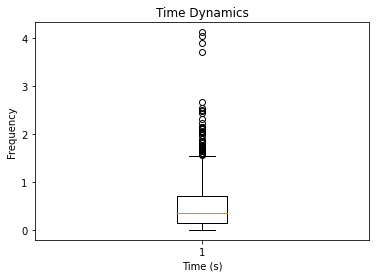

In [6]:
plt.boxplot(sims_array_1);
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Time Dynamics')

In [7]:
def state_reactions(self, species=1):
    """ Input: 
            Dictionary of Reactions where {Reaction Name: Reaction Propensity}
        Output: 
            Dictionary of Reaction Activity where {Reaction Name: Reaction Activity}
    """
    reactions_list = list(self.reactions.keys())
    propenisties_list = list(self.reactions.values())

    propensities_calculated = list(map(lambda propensity: -(1/propensity * species) * np.log(rand()), propenisties_list))
    reactions_activity_dict = dict(zip(reactions_list, propensities_calculated))

    return reactions_activity_dict

def min_argmin(self):
    """ Input: 
            Dictionary of Reaction Activity where {Reaction Name: Reaction Activity}
        Output: 
            Tau Time and Tau Argument
    """
    tau = np.min(list(self.reactions.values()))
    tau_arg = np.argmin(list(self.reactions.values()))

    tau_dict = {'tau': tau, 'tau_idx': tau_arg}

    return tau_dict

In [17]:


class Gillespie:

    def __init__(self, tmax=10, sampling_time = 0.01,reaction_model = object):
        self.sampling_time = sampling_time      # Sampling Time
        self.time = 0                           # Iitial Time
        self.reference_time = 0                 # Reference Time
        self.tmax = tmax                        # Total Time
        self._reaction_model_copy = copy.copy(reaction_model)
        self.reaction_model = reaction_model    # Object of reaction model
        self.tau = 0
        self.tarr = [0]
        self.protarr = [0]

    def simulate(self):
        """ 
            Performs Cesar Nieto et-al Gillespie algorithm
            for chemical reactions simulations.
        """

        while self.time < self.tmax:

            propensities = self.reaction_model.calculate_propensities()
            propenisties_list = list(propensities.values())
            possible_reactions = None

            warnings.simplefilter("ignore")
            reaction_times = lambda propensity, random_num: -(1/propensity) * np.log(random_num)
            random_array = [np.random.rand() for k in range(len(propenisties_list))]

            calculated_propensities = list(map(reaction_times, propenisties_list, random_array))
            reactions_dict = dict(enumerate(list(self.reaction_model.show_reactions().keys())))
            
            self.tau = np.min(calculated_propensities)     # tau time
            q = np.argmin(calculated_propensities)    # Reaction that occurs

            if self.time + self.tau < self.reference_time:
                possible_reactions = self.reaction_model.show_q()[reactions_dict[q]]

                create_species = possible_reactions['create']
                [self.reaction_model.create(name=species) for species in create_species if species != None]

                destroy_species = possible_reactions['destroy']
                [self.reaction_model.destroy(name=species) for species in destroy_species if species != None]


                self.time += self.tau
                
            else:
                self.time = self.reference_time  

                self.tarr.append(self.time)
                self.protarr.append(self.reaction_model.show_species()['protein'])

                self.reference_time += self.sampling_time
        
        print(f'Propensities: {calculated_propensities}')
        print(reactions_dict)
        print(reactions_dict[q])
        print(self.reaction_model.show_species())
        plt.plot(self.tarr, self.protarr)
        self.reaction_model = self._reaction_model_copy


class ReactionModel:
    
    def __init__(self, reactions=dict,species=dict, propensities=dict, q=dict):
        self.reactions = reactions
        self.species = species 
        self.propensities = propensities
        self.q = q
    
    def show_species(self):
        return self.species

    def show_reactions(self):
        return self.reactions

    def show_propensities(self):
        return self.propensities
    
    def show_q(self):
        return self.q
    
    def calculate_propensities(self):
        
        complete_propensity = list(self.reactions.values())
        reaction_names = self.reactions.keys()
        species_copy = copy.copy(self.species)
        species_copy.update(self.propensities)

        species_calculus = []

        for i in range(len(complete_propensity)):
            propensities_array = []
            species_calculus.append(propensities_array)

            for k in complete_propensity[i]:
                propensities_array.append(species_copy[k])
                
        propensities_result = list(map(np.prod, species_calculus))
        
        return dict(zip(reaction_names, propensities_result))
    
    def create(self, name=str):
        self.species[name] += 1
    
    def destroy(self, name=str):
        self.species[name] -= 1
    
    def set_q(self):
        pass
        

In [20]:


species = {
            'dna': 1, 
            'rna': 0, 
            'protein': 0, 
            'complex': 0
            }

propensities = {
                'trc_c':    0.3, 
                'trl_c':    10.02, 
                'pdeg_d':   np.log(2)/2.5, 
                'cmplx_c':  np.log(2)/60,
                'cmplx_d':  0.3
            }

reactions = {
            'transcription': ['trc_c', 'dna'], 
            'translation':   ['trl_c', 'rna'], 
            'degradation':   ['pdeg_d', 'protein'], 
            'complex_c':     ['cmplx_c', 'dna', 'protein'],
            'complex_d':     ['cmplx_d', 'complex']
            }

q = {
        'transcription': {'create': ['rna'],            'destroy': [None]}, 
        'translation':   {'create': ['protein'],        'destroy': [None]}, 
        'degradation':   {'create': [None],             'destroy': ['protein']}, 
        'complex_c':     {'create': ['complex'],        'destroy': ['dna', 'protein']},
        'complex_d':     {'create': ['dna', 'protein'], 'destroy': ['complex']}
    }        




Propensities: [inf, 0.0009565315990206209, 0.012558823148556676, inf, 1.9748207812780816]
{0: 'transcription', 1: 'translation', 2: 'degradation', 3: 'complex_c', 4: 'complex_d'}
translation
{'dna': 0, 'rna': 10, 'protein': 377, 'complex': 1}


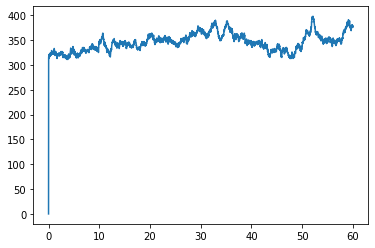

In [24]:
model_2 = ReactionModel(reactions=reactions,species=species, propensities=propensities, q=q)
Gillespie(tmax=60, sampling_time=0.01,reaction_model = model_2).simulate();

In [11]:
x = [4,5,6,7,8]
dict(enumerate(x))

{0: 4, 1: 5, 2: 6, 3: 7, 4: 8}

[0.017752532107354686, 0.017077176687844704]
0.017077176687844704
1


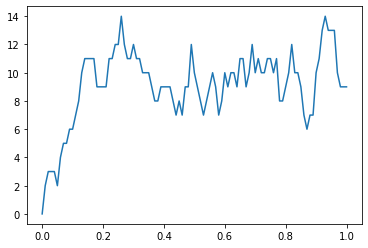

In [12]:
kr=100
gammar=10
t=0#tiempo
proteins=0#condicion inicial
tarray=[]
protarr=[]
samp_time=0.01
tref=0
tmax = 1
tau = 0

while t<tmax:
    
    if proteins > 0:

        tcrea = -(1/kr)*np.log(rand())
        tdeg = -(1/(gammar*proteins))*np.log(rand())

        tau = np.min([tcrea,tdeg])
        
        reac = np.argmin([tcrea,tdeg])
    
    elif proteins == 0:
        R=np.random.rand()
        tau=-(1/kr)*np.log(R)
        reac = 0
        
    if t + tau < tref:
        
        if reac == 0:
            proteins += 1
        else:
            proteins -= 1

        t += tau
        
    elif t + tau > tref:
        t = tref  

        tarray.append(t)
        protarr.append(proteins)

        tref += samp_time    
print([tcrea,tdeg])
print(tau)
print(reac)
plt.plot(tarray,protarr)

In [13]:
u = {1:2, 3:4}
u[1]


2

In [14]:
list(map(lambda x, y, z: (x ** y) + z, [2,3], [1,4], [9,4]))

[11, 85]

In [15]:
propenisties_list_ = [0.005,0.167,np.log(2)/150]
quantity_list = [10,1000,10]
reaction_times = lambda propensity, quantity: -(1/(propensity * quantity)) * np.log(rand())
o = map(reaction_times, propenisties_list_, quantity_list)
list(o)

[24.37451740557037, 0.004531650123183533, 9.558882172690039]

In [16]:
print()